In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder,StandardScaler,OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime

from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.max_columns', None)

3A. Game Recommendation System

In [104]:
df3 = pd.read_csv('3A.tsv', sep="\t")
df3

,index,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,-706.0,NaN,NaN
2,2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,-92.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16923,16923,Aliens: Colonial Marines,PS3,2013,Shooter,Sega,0.20,0.29,0.00,0.11,0.60,43.0,25.0,3.6,295.0,Gearbox Software,M
16924,16924,Backyard Wrestling: Don't Try This at Home,PS2,2003,Fighting,Eidos Interactive,0.30,0.23,0.00,0.08,0.60,51.0,24.0,7.8,29.0,Paradox Development,M
16925,16925,Yakuza: Dead Souls,PS3,2011,Shooter,Sega,0.09,0.06,0.42,0.03,0.60,64.0,55.0,7.4,69.0,Ryu ga Gotoku Studios,M
16926,16926,Fight Night Round 2,XB,2005,Fighting,Electronic Arts,0.42,0.16,0.00,0.02,0.60,88.0,48.0,8.8,27.0,EA Sports,T


mengambil beberapa kolom yang diperlukan untuk membuat sistem rekomendasi

In [105]:
df3_filtered = df3[['Name', 'Platform', 'Genre', 'Critic_Score', 'User_Score', 'Rating']]
df3_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16928 entries, 0 to 16927
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          16926 non-null  object 
 1   Platform      16928 non-null  object 
 2   Genre         16926 non-null  object 
 3   Critic_Score  8260 non-null   float64
 4   User_Score    10159 non-null  object 
 5   Rating        10092 non-null  object 
dtypes: float64(1), object(5)
memory usage: 793.6+ KB


A. Exploratory Data Analysis (EDA)

In [106]:
print(df3_filtered.isnull().sum())

Name               2
Platform           0
Genre              2
Critic_Score    8668
User_Score      6769
Rating          6836
dtype: int64


Removing missing value

In [107]:
df3_filtered.dropna(subset=['Name', 'Genre', 'Rating'], axis=0, inplace=True)
df3_filtered = df3_filtered.reset_index(drop=True)

df3_filtered[['Name', 'Genre', 'Rating']].isna().sum()

Name      0
Genre     0
Rating    0
dtype: int64

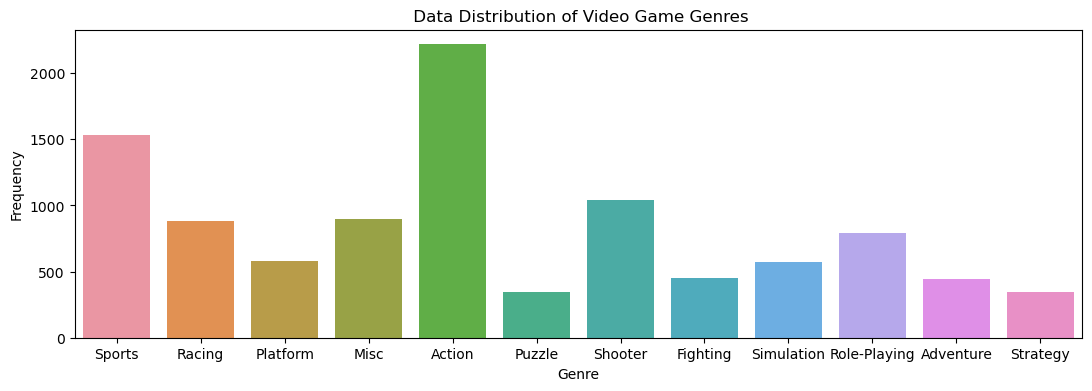

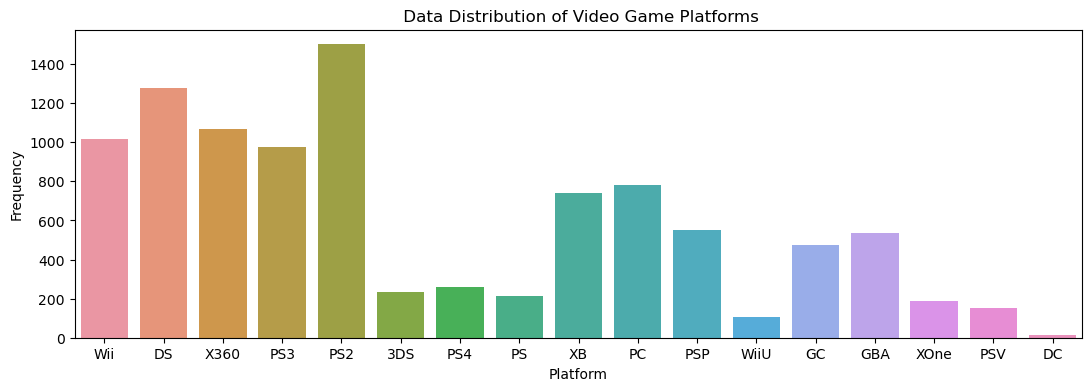

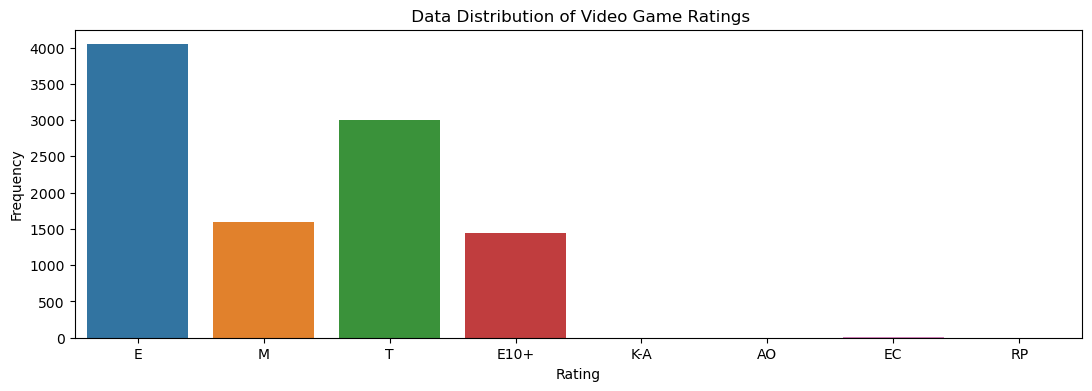

In [108]:
features = df3_filtered[['Genre', 'Platform', 'Rating']].columns

for idx, feature in enumerate(features):
    plt.figure(figsize = (13,4))
    sns.countplot(data=df3_filtered, x=feature)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(" Data Distribution of Video Game " + feature + "s")
plt.show()

pada hasil distribusi diatas kita bisa melihat bahwa ada beberapa kelangkaan pada platforms DC, dan rating seperti K-A, AO, EC, dan RP

Disini saya membuat fitur tambahan yang sesuai dengan variabel User_Score dan Critic_score. Lalu mengganti semua nilai yang hilang dan 'tbd' menjadi NaN
Data digantin menggunakan mean dari fitur dalam genre tertentu, misal mean semua skor di bawah kategori 'Action'.

In [109]:
# Replace 'tbd' value to NaN
df3_filtered['User_Score'] = np.where(df3_filtered['User_Score'] == 'tbd', 
                                                 np.nan, 
                                                 df3_filtered['User_Score']).astype(float)

# Group the records by Genre, then aggregate them calculating the average of both Critic Score and User Score
df3_genre = df3_filtered[['Genre', 'Critic_Score', 'User_Score']].groupby('Genre', as_index=False)
df3_score_mean = df3_genre.agg(Ave_Critic_Score = ('Critic_Score', 'mean'), Ave_User_Score = ('User_Score', 'mean'))

# Merge the average scores with the main dataframe
df3_filtered = df3_filtered.merge(df3_score_mean, on='Genre')
df3_filtered

,Name,Platform,Genre,Critic_Score,User_Score,Rating,Ave_Critic_Score,Ave_User_Score
0,Wii Sports,Wii,Sports,76.0,8.0,E,72.122924,6.969148
1,Wii Sports Resort,Wii,Sports,80.0,8.0,E,72.122924,6.969148
2,Wii Fit,Wii,Sports,80.0,7.7,E,72.122924,6.969148
3,Wii Fit Plus,Wii,Sports,80.0,7.4,E,72.122924,6.969148
4,FIFA 16,PS4,Sports,82.0,4.3,E,72.122924,6.969148
...,...,...,...,...,...,...,...,...
10087,Worms 2,PC,Strategy,NaN,8.1,K-A,72.361775,7.324342
10088,STORM: Frontline Nation,PC,Strategy,60.0,7.2,E10+,72.361775,7.324342
10089,XCOM: Enemy Unknown,X360,Strategy,90.0,8.3,M,72.361775,7.324342
10090,Battle of Giants: Dragons,DS,Strategy,NaN,6.0,E10+,72.361775,7.324342


In [110]:
df3_filtered['Critic_Score_Imputed'] = np.where(df3_filtered['Critic_Score'].isna(), 
                                                           df3_filtered['Ave_Critic_Score'], 
                                                           df3_filtered['Critic_Score'])

df3_filtered['User_Score_Imputed'] = np.where(df3_filtered['User_Score'].isna(), 
                                                         df3_filtered['Ave_User_Score'], 
                                                         df3_filtered['User_Score'])
df3_filtered

,Name,Platform,Genre,Critic_Score,User_Score,Rating,Ave_Critic_Score,Ave_User_Score,Critic_Score_Imputed,User_Score_Imputed
0,Wii Sports,Wii,Sports,76.0,8.0,E,72.122924,6.969148,76.000000,8.0
1,Wii Sports Resort,Wii,Sports,80.0,8.0,E,72.122924,6.969148,80.000000,8.0
2,Wii Fit,Wii,Sports,80.0,7.7,E,72.122924,6.969148,80.000000,7.7
3,Wii Fit Plus,Wii,Sports,80.0,7.4,E,72.122924,6.969148,80.000000,7.4
4,FIFA 16,PS4,Sports,82.0,4.3,E,72.122924,6.969148,82.000000,4.3
...,...,...,...,...,...,...,...,...,...,...
10087,Worms 2,PC,Strategy,NaN,8.1,K-A,72.361775,7.324342,72.361775,8.1
10088,STORM: Frontline Nation,PC,Strategy,60.0,7.2,E10+,72.361775,7.324342,60.000000,7.2
10089,XCOM: Enemy Unknown,X360,Strategy,90.0,8.3,M,72.361775,7.324342,90.000000,8.3
10090,Battle of Giants: Dragons,DS,Strategy,NaN,6.0,E10+,72.361775,7.324342,72.361775,6.0


Saya ingin membandingkan apakah ada perubahan signifikan ketika saya mengisi missing values, dan dapat dilihat dibawah bahwa tidadk ada perubahan yang signifikan di mean dan std nya

In [111]:
df3_filtered[['Critic_Score', 'Critic_Score_Imputed', 'User_Score', 'User_Score_Imputed']].describe()

,Critic_Score,Critic_Score_Imputed,User_Score,User_Score_Imputed
count,8176.000000,10092.000000,7631.000000,10092.000000
mean,69.041585,68.919637,7.127795,7.108892
std,13.957243,12.604837,1.499694,1.306630
min,13.000000,13.000000,0.000000,0.000000
25%,60.000000,63.000000,6.400000,6.800000
50%,71.000000,69.000000,7.500000,7.132164
75%,79.000000,77.000000,8.200000,8.000000
max,98.000000,98.000000,9.700000,9.700000


Karena Ave_Critic_Score dan Ave_User_Score sudah tidak diperlukan maka bisa dihilangkan, jangan lupa untuk mengganti kembali nama variabel yang sempat berubah

In [112]:
df3_final = df3_filtered.drop(columns=['User_Score', 'Critic_Score', 'Ave_Critic_Score', 'Ave_User_Score'], axis=1)
df3_final = df3_final.reset_index(drop=True)

df3_final = df3_final.rename(columns={'Critic_Score_Imputed':'Critic_Score', 'User_Score_Imputed':'User_Score'})
df3_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10092 entries, 0 to 10091
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          10092 non-null  object 
 1   Platform      10092 non-null  object 
 2   Genre         10092 non-null  object 
 3   Rating        10092 non-null  object 
 4   Critic_Score  10092 non-null  float64
 5   User_Score    10092 non-null  float64
dtypes: float64(2), object(4)
memory usage: 473.2+ KB


Sekarang saya ingin melihat distribusi dari critic_score dan user_score serta corelasi antara keduanya

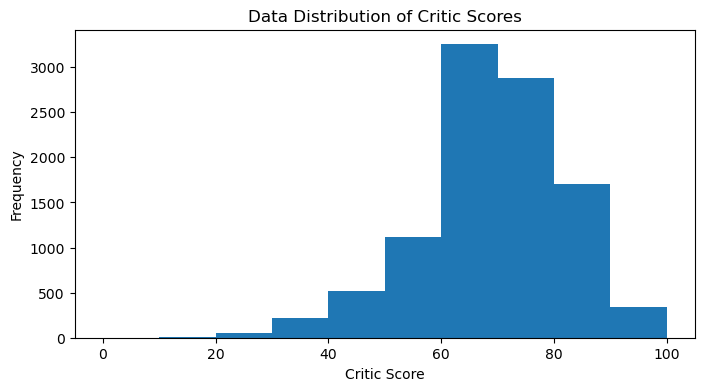

In [113]:
hist, bins = np.histogram(df3_final['Critic_Score'], bins=10, range=(0, 100))

plt.figure(figsize = (8,4))
plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]), align='edge')
plt.xlabel('Critic Score')
plt.ylabel('Frequency')
plt.title("Data Distribution of Critic Scores")
plt.show()

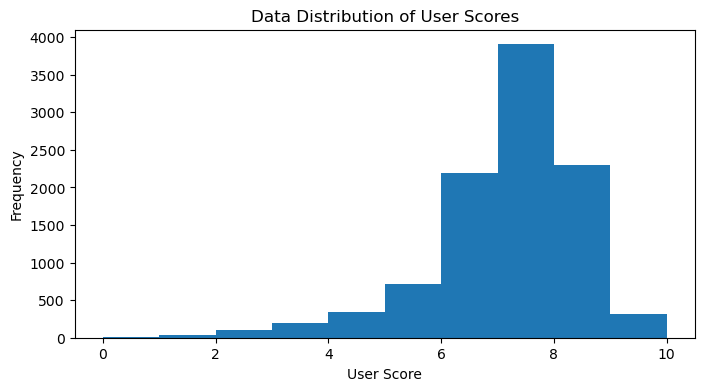

In [114]:
hist, bins = np.histogram(df3_final['User_Score'], bins=10, range=(0, 10))

plt.figure(figsize = (8,4))
plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]), align='edge')
plt.xlabel('User Score')
plt.ylabel('Frequency')
plt.title("Data Distribution of User Scores")
plt.show()

[Text(0.5, 0, 'User Score'),
 Text(0, 0.5, 'Critic Score'),
 Text(0.5, 1.0, 'User Scores vs. Critic Scores')]

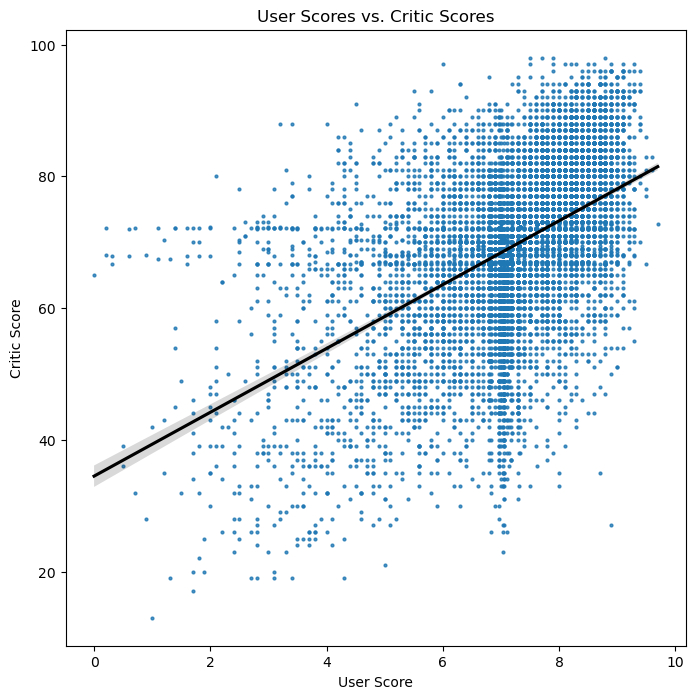

In [115]:
plt.figure(figsize=(8, 8))
ax = sns.regplot(x=df3_final['User_Score'], y=df3_final['Critic_Score'], 
                 line_kws={"color": "black"}, scatter_kws={'s': 4})
ax.set(xlabel ="User Score", ylabel = "Critic Score", title="User Scores vs. Critic Scores")

In [116]:
categorical_columns = [name for name in df3_final.columns if df3_final[name].dtype=='O']
categorical_columns = categorical_columns[1:]

print(f'There are {len(categorical_columns)} categorical features:\n')
print(", ".join(categorical_columns))

There are 3 categorical features:

Platform, Genre, Rating


In [117]:
df_dummy = pd.get_dummies(data=df3_final, columns=categorical_columns)
df_dummy.head(5)

,Name,Critic_Score,User_Score,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,Platform_PS2,Platform_PS3,Platform_PS4,Platform_PSP,Platform_PSV,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne,Genre_Action,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Rating_AO,Rating_E,Rating_E10+,Rating_EC,Rating_K-A,Rating_M,Rating_RP,Rating_T
0,Wii Sports,76.0,8.0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False
1,Wii Sports Resort,80.0,8.0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False
2,Wii Fit,80.0,7.7,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False
3,Wii Fit Plus,80.0,7.4,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False
4,FIFA 16,82.0,4.3,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False


In [118]:
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10092 entries, 0 to 10091
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                10092 non-null  object 
 1   Critic_Score        10092 non-null  float64
 2   User_Score          10092 non-null  float64
 3   Platform_3DS        10092 non-null  bool   
 4   Platform_DC         10092 non-null  bool   
 5   Platform_DS         10092 non-null  bool   
 6   Platform_GBA        10092 non-null  bool   
 7   Platform_GC         10092 non-null  bool   
 8   Platform_PC         10092 non-null  bool   
 9   Platform_PS         10092 non-null  bool   
 10  Platform_PS2        10092 non-null  bool   
 11  Platform_PS3        10092 non-null  bool   
 12  Platform_PS4        10092 non-null  bool   
 13  Platform_PSP        10092 non-null  bool   
 14  Platform_PSV        10092 non-null  bool   
 15  Platform_Wii        10092 non-null  bool   
 16  Plat

In [119]:
features = df_dummy.drop(columns=['Name'], axis=1)

scale = StandardScaler()
scaled_features = scale.fit_transform(features)
scaled_features = pd.DataFrame(scaled_features, columns=features.columns)

scaled_features.head(5)

,Critic_Score,User_Score,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,Platform_PS2,Platform_PS3,Platform_PS4,Platform_PSP,Platform_PSV,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne,Genre_Action,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Rating_AO,Rating_E,Rating_E10+,Rating_EC,Rating_K-A,Rating_M,Rating_RP,Rating_T
0,0.561746,0.682023,-0.153731,-0.037271,-0.381125,-0.236834,-0.222242,-0.289418,-0.146836,-0.417992,-0.327393,-0.161974,-0.239852,-0.12366,2.985558,-0.103028,-0.344202,-0.281501,-0.138521,-0.530588,-0.215279,-0.215531,-0.312144,-0.247158,-0.187572,-0.309844,-0.291024,-0.338775,-0.245348,2.361965,-0.187288,-0.009955,1.223179,-0.40813,-0.028166,-0.017244,-0.432452,-0.017244,-0.650856
1,0.879100,0.682023,-0.153731,-0.037271,-0.381125,-0.236834,-0.222242,-0.289418,-0.146836,-0.417992,-0.327393,-0.161974,-0.239852,-0.12366,2.985558,-0.103028,-0.344202,-0.281501,-0.138521,-0.530588,-0.215279,-0.215531,-0.312144,-0.247158,-0.187572,-0.309844,-0.291024,-0.338775,-0.245348,2.361965,-0.187288,-0.009955,1.223179,-0.40813,-0.028166,-0.017244,-0.432452,-0.017244,-0.650856
2,0.879100,0.452414,-0.153731,-0.037271,-0.381125,-0.236834,-0.222242,-0.289418,-0.146836,-0.417992,-0.327393,-0.161974,-0.239852,-0.12366,2.985558,-0.103028,-0.344202,-0.281501,-0.138521,-0.530588,-0.215279,-0.215531,-0.312144,-0.247158,-0.187572,-0.309844,-0.291024,-0.338775,-0.245348,2.361965,-0.187288,-0.009955,1.223179,-0.40813,-0.028166,-0.017244,-0.432452,-0.017244,-0.650856
3,0.879100,0.222804,-0.153731,-0.037271,-0.381125,-0.236834,-0.222242,-0.289418,-0.146836,-0.417992,-0.327393,-0.161974,-0.239852,-0.12366,2.985558,-0.103028,-0.344202,-0.281501,-0.138521,-0.530588,-0.215279,-0.215531,-0.312144,-0.247158,-0.187572,-0.309844,-0.291024,-0.338775,-0.245348,2.361965,-0.187288,-0.009955,1.223179,-0.40813,-0.028166,-0.017244,-0.432452,-0.017244,-0.650856
4,1.037777,-2.149828,-0.153731,-0.037271,-0.381125,-0.236834,-0.222242,-0.289418,-0.146836,-0.417992,-0.327393,6.173838,-0.239852,-0.12366,-0.334946,-0.103028,-0.344202,-0.281501,-0.138521,-0.530588,-0.215279,-0.215531,-0.312144,-0.247158,-0.187572,-0.309844,-0.291024,-0.338775,-0.245348,2.361965,-0.187288,-0.009955,1.223179,-0.40813,-0.028166,-0.017244,-0.432452,-0.017244,-0.650856


B. Recommender System

In [120]:
model = NearestNeighbors(n_neighbors=11, metric='cosine', algorithm='brute').fit(scaled_features)
print(model)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=11)


In [121]:
vg_distances, vg_indices = model.kneighbors(scaled_features)

print("List of indexes and distances for the first 5 games:\n")
print(vg_indices[:5], "\n")
print(vg_distances[:5])

List of indexes and distances for the first 5 games:

[[   0  544  655  168    1  615  482    2  259  556  164]
 [   1  482  168    2  259    0  544  468  702  181  441]
 [   2    1    3  482  168    0  275  544  324  259  441]
 [   3  275    2  324  190    1  482  168    0  261  199]
 [   4  103    5  250    9 1316   37   83   40  147   97]] 

[[0.00000000e+00 1.45831009e-04 7.96222468e-04 1.52486205e-03
  2.48594117e-03 2.76463157e-03 3.85876104e-03 3.90263610e-03
  4.57325233e-03 4.77268281e-03 4.77631809e-03]
 [1.11022302e-16 1.50533686e-04 3.04527574e-04 1.30820486e-03
  2.23903039e-03 2.48594117e-03 2.65554134e-03 2.71986185e-03
  3.38726679e-03 3.38726679e-03 3.43626276e-03]
 [0.00000000e+00 1.30820486e-03 1.33604493e-03 1.43102834e-03
  2.50632035e-03 3.90263610e-03 4.34248366e-03 4.94518685e-03
  5.12705239e-03 6.96419938e-03 7.16559618e-03]
 [0.00000000e+00 1.21405740e-03 1.33604493e-03 2.01578134e-03
  2.78504588e-03 5.28485727e-03 5.37935096e-03 7.38282791e-03
  7.98202990e

In [122]:
game_names = df_dummy['Name'].drop_duplicates()
game_names = game_names.reset_index(drop=True)

vectorizer = TfidfVectorizer(use_idf=True).fit(game_names)
print(vectorizer)

TfidfVectorizer()


In [123]:
def VideoGameRecommender(video_game_name, video_game_platform='Any'):
    # untuk memberikan rekomendasi game berdasarkan fitur-fitur dari game
    default_platform = 'Any'

    # User input: Game Title and Platform
    if video_game_platform != default_platform:
        video_game_idx = df3_final.query("Name == @video_game_name & Platform == @video_game_platform").index
        
        if video_game_idx.empty:
            video_game_idx = df3_final.query("Name == @video_game_name").index

            if not video_game_idx.empty:
                print(f"Note: Recommendations will be based on the title of the game as it is not available on the specified platform.\n")
                video_game_platform = default_platform
    
    # User input: Game Title only
    else:
        video_game_idx = df3_final.query("Name == @video_game_name").index  
    
    if video_game_idx.empty:
        # Kalau game yang dimasukin user tidak ada di record maka akan direkomen game baru yang mirip dengan input
        closest_match_game_name = VideoGameTitleRecommender(video_game_name)

        print(f"'{video_game_name}' doesn't exist in the records.\n")
        print(f"You may want to try '{closest_match_game_name}', which is the closest match to the input.")
    
    else:
        # User input: Game Title only
        if video_game_platform == default_platform:

            # Place in a separate dataframe the indices and distances, then sort the record by distance in ascending order       
            vg_combined_dist_idx_df = pd.DataFrame()
            for idx in video_game_idx:
                # Remove from the list any game that shares the same name as the input
                vg_dist_idx_df = pd.concat([pd.DataFrame(vg_indices[idx][1:]), pd.DataFrame(vg_distances[idx][1:])], axis=1)
                vg_combined_dist_idx_df = pd.concat([vg_combined_dist_idx_df, vg_dist_idx_df])

            vg_combined_dist_idx_df = vg_combined_dist_idx_df.set_axis(['Index', 'Distance'], axis=1)
            vg_combined_dist_idx_df = vg_combined_dist_idx_df.reset_index(drop=True)
            vg_combined_dist_idx_df = vg_combined_dist_idx_df.sort_values(by='Distance', ascending=True)

            video_game_list = df3_final.iloc[vg_combined_dist_idx_df['Index']]

            # Menghapus semua nama duplikat agar user dapat melihat banyak pilihan
            video_game_list = video_game_list.drop_duplicates(subset=['Name'], keep='first')
            
            # Menampikan 5 game dalam list
            video_game_list = video_game_list.head(5)

            # Get the distance of the games similar to the input
            recommended_distances = np.array(vg_combined_dist_idx_df['Distance'].head(5))

        # User input: Game Title and Platform
        else:
            # Remove from the list any game that shares the same name as the input
            recommended_idx = vg_indices[video_game_idx[0]][1:]
            video_game_list = df3_final.iloc[recommended_idx]

            # Get the distance of the games similar to the input
            recommended_distances = np.array(vg_distances[video_game_idx[0]][1:])

        # Limit the output to the top 5 recommendations
        top_n = 5
        video_game_list = video_game_list.head(top_n)
        recommended_distances = recommended_distances[:top_n]

        print(f"Top {top_n} Recommended Video Games for '{video_game_name}' [platform: {video_game_platform}]")

        video_game_list = video_game_list.reset_index(drop=True)
        recommended_video_game_list = pd.concat([video_game_list, 
                                                 pd.DataFrame(recommended_distances, columns=['Similarity_Distance'])], axis=1)

        recommended_video_game_list.reset_index(drop=True, inplace=True)
        
        # Display the DataFrame without the index
        display(recommended_video_game_list)

In [124]:
VideoGameRecommender('Call of Duty: World at War')

Top 5 Recommended Video Games for 'Call of Duty: World at War' [platform: Any]


,Name,Platform,Genre,Rating,Critic_Score,User_Score,Similarity_Distance
0,Call of Duty: World at War,X360,Shooter,M,84.0,7.6,2.220446e-16
1,Halo: Combat Evolved,PC,Shooter,M,83.0,7.4,9.544818e-05
2,Red Faction: Guerrilla,PC,Shooter,M,82.0,7.5,9.910022e-05
3,Battlefield 3,PS3,Shooter,M,85.0,7.5,1.026779e-04
4,Tom Clancy's Rainbow Six: Vegas,PS3,Shooter,M,86.0,7.6,1.026779e-04


In [125]:
VideoGameRecommender('Red Faction: Guerrilla', 'PS3')

Top 5 Recommended Video Games for 'Red Faction: Guerrilla' [platform: PS3]


,Name,Platform,Genre,Rating,Critic_Score,User_Score,Similarity_Distance
0,Resistance: Fall of Man,PS3,Shooter,M,86.0,8.1,0.000102
1,Vanquish,PS3,Shooter,M,84.0,8.1,0.000104
2,Vanquish,PS3,Shooter,M,84.0,8.1,0.000104
3,Killzone 3,PS3,Shooter,M,84.0,7.9,0.000494
4,Borderlands,PS3,Shooter,M,83.0,7.9,0.000798


In [126]:
VideoGameRecommender('Call of Duty: World at War', 'XB')

Note: Recommendations will be based on the title of the game as it is not available on the specified platform.

Top 5 Recommended Video Games for 'Call of Duty: World at War' [platform: Any]


,Name,Platform,Genre,Rating,Critic_Score,User_Score,Similarity_Distance
0,Call of Duty: World at War,X360,Shooter,M,84.0,7.6,2.220446e-16
1,Halo: Combat Evolved,PC,Shooter,M,83.0,7.4,9.544818e-05
2,Red Faction: Guerrilla,PC,Shooter,M,82.0,7.5,9.910022e-05
3,Battlefield 3,PS3,Shooter,M,85.0,7.5,1.026779e-04
4,Tom Clancy's Rainbow Six: Vegas,PS3,Shooter,M,86.0,7.6,1.026779e-04
